# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch


In [3]:
# Necessary for loading data and modeling in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bbody','0bfaces','0bplaces','0btools','2bbody','2bfaces','2bplaces','2btools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [6]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# # @title Download the data

# # @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

# import os, requests, tarfile

# fnames = ["hcp_rest.tgz",
#           "hcp_task.tgz",
#           "hcp_covariates.tgz",
#           "atlas.npz"]
# urls = ["https://osf.io/bqp7m/download",
#         "https://osf.io/s4h8j/download",
#         "https://osf.io/x5p4g/download",
#         "https://osf.io/j5kuc/download"]

# for fname, url in zip(fnames, urls):
#   if not os.path.isfile(fname):
#     try:
#       r = requests.get(url)
#     except requests.ConnectionError:
#       print("!!! Failed to download data !!!")
#     else:
#       if r.status_code != requests.codes.ok:
#         print("!!! Failed to download data !!!")
#       else:
#         print(f"Downloading {fname}...")
#         with open(fname, "wb") as fid:
#           fid.write(r.content)
#         print(f"Download {fname} completed!")

In [7]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [ ]:
# # @title Extract the data in `HCP_DIR`
# fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

# for fname in fnames:
#   # open file
#   path_name = os.path.join(HCP_DIR, fname)
#   if not os.path.exists(path_name):
#     print(f"Extracting {fname}.tgz...")
#     with tarfile.open(f"{fname}.tgz") as fzip:
#       fzip.extractall(HCP_DIR)
#   else:
#     print(f"File {fname}.tgz has already been extracted.")

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [9]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  taskey = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{taskey}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [10]:
my_exp = 'GAMBLING'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 253)


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [11]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [12]:
my_exp = 'GAMBLING'
my_regions = [*range(360)]



In [13]:
def get_subject_gender(subject_id: str, dataframe: pd.DataFrame) -> int:
    """
    Determina el género de un sujeto y lo codifica como valor binario.
    
    Args:
        subject_id (str): ID del sujeto en el formato del HCP dataset
        dataframe (pd.DataFrame): DataFrame que contiene la información demográfica
                                Debe tener columnas 'Subject_ID' y 'Gender'
    
    Returns:
        int: 1 para género femenino ('F'), 0 para género masculino ('M')
        
    Raises:
        KeyError: Si el subject_id no se encuentra en el DataFrame
        ValueError: Si el género no es 'F' o 'M'
    """
    try:
        # Convertir subject_id a int para matching con el DataFrame
        subject_int = int(subject_id)
        
        # Obtener las filas que coinciden con el subject_id
        matches = dataframe[dataframe['Subject_ID'] == subject_int]
        
        if len(matches) == 0:
            raise KeyError(f"Subject ID {subject_id} no encontrado en el DataFrame")
            
        if len(matches) > 1:
            print(f"Advertencia: Múltiples entradas para Subject ID {subject_id}")
            
        # Obtener el género del primer match
        gender = matches['Gender'].iloc[0]
        
        # Validar y codificar el género
        if gender not in ['F', 'M']:
            raise ValueError(f"Género inválido: {gender}")
            
        return 1 if gender == 'F' else 0
        
    except ValueError as e:
        print(f"Error al procesar subject_id {subject_id}: {str(e)}")
        raise
    except Exception as e:
        print(f"Error inesperado al procesar subject_id {subject_id}: {str(e)}")
        raise

# Ejemplo de uso:
# gender_list = []
# for i, subject in enumerate(subjects):
#     gender = get_subject_gender(subject, HCP_data_frame)
#     gender_list.append(gender)

(360, 253)
[[array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]), array([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171])], [array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49]), array([193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231])]]
2
2
(360, 39)


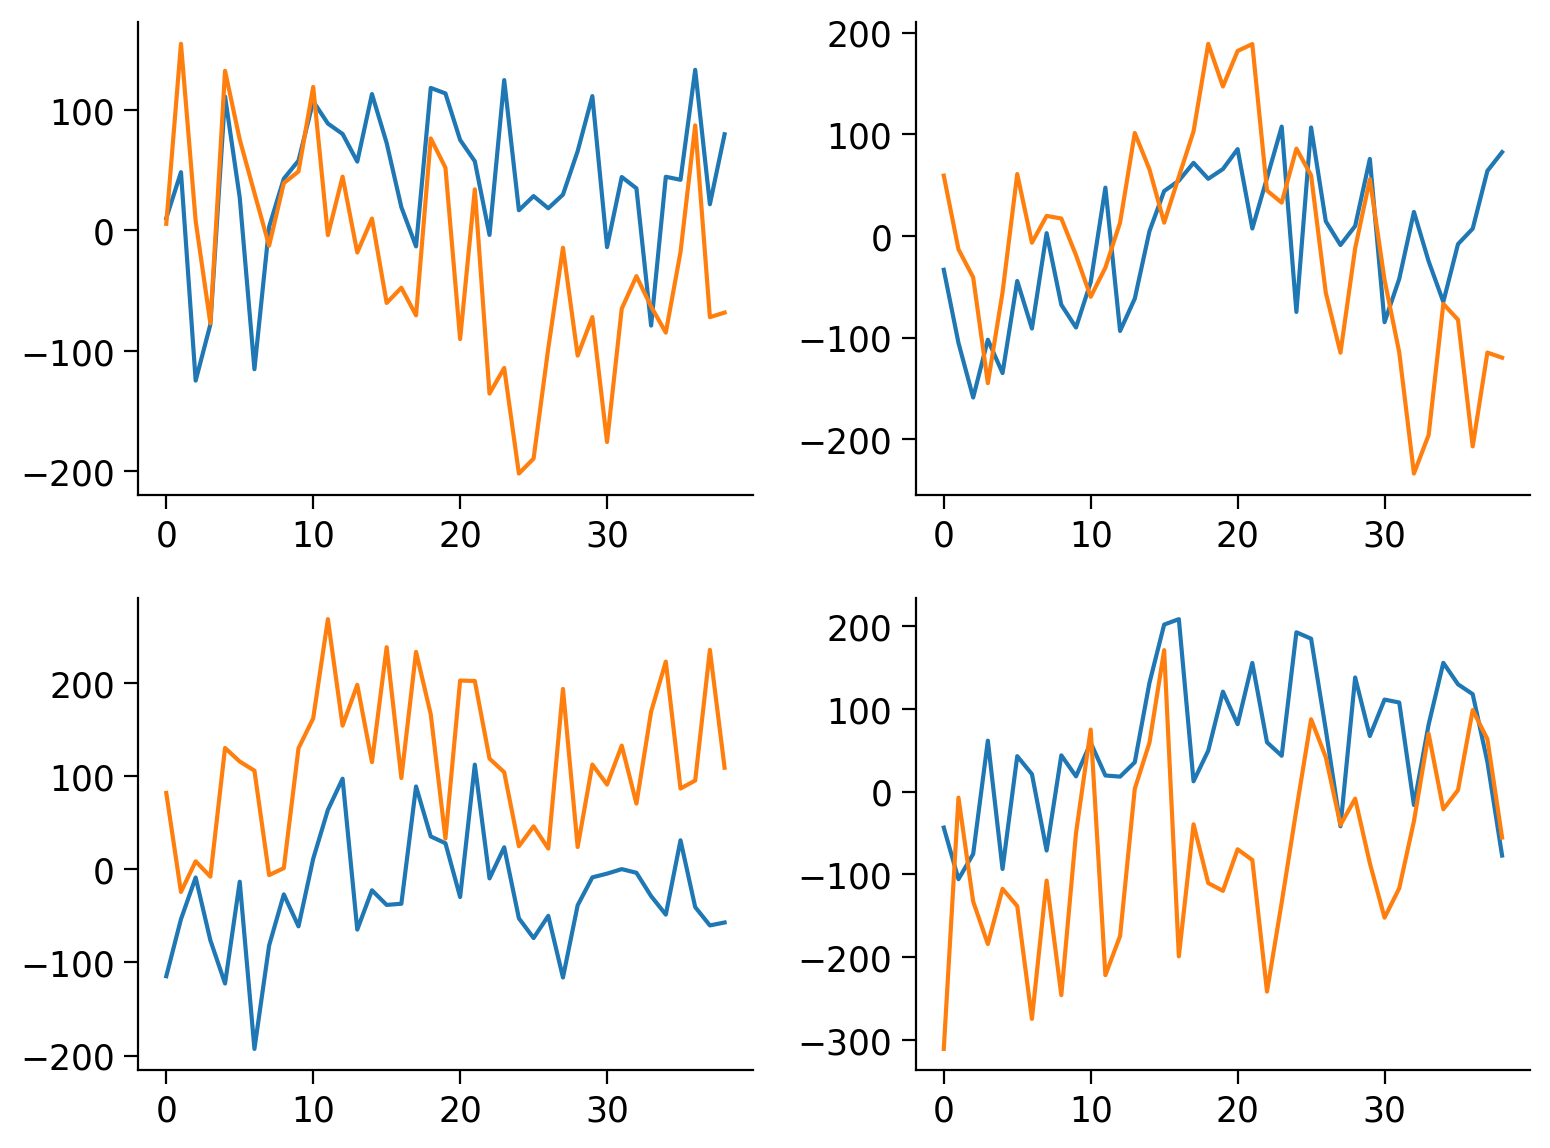

In [14]:
print(data.shape)
print(evs)
print(len(evs))
print(len(evs[0]))

print(data[:,evs[0][0]].shape)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(data[[164, 344],:][:,evs[0][0]].T)
axs[0, 1].plot(data[[164, 344],:][:,evs[0][1]].T)
axs[1, 0].plot(data[[164, 344],:][:,evs[1][0]].T)
axs[1, 1].plot(data[[164, 344],:][:,evs[1][1]].T)
plt.show()

## Model

In [16]:
class LSTMRegression(torch.nn.Module):

    def __init__(self,n_features,seq_length, n_hidden, n_layers):
        super(LSTMRegression, self).__init__()

        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = n_hidden # number of hidden states 3 35 20
        self.n_layers = n_layers # number of LSTM layers (stacked) 7 2 4

        self.l_lstm = torch.nn.LSTM(input_size = n_features,
                                    hidden_size = self.n_hidden,
                                    num_layers = self.n_layers,
                                    batch_first = True, dropout=.3)
        self.l_linear = torch.nn.Linear(self.n_hidden, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x, (self.hidden, _) = self.l_lstm(x)
        return torch.sigmoid(self.l_linear(x[:,-1,:]))
        # return self.l_linear(x[:,-1,:])

In [17]:
class LSTMRegressionCond(torch.nn.Module):

    def __init__(self,n_features,seq_length, n_hidden, n_layers, n_add, n_add_hidden):
        super(LSTMRegression, self).__init__()

        self.n_features   = n_features
        self.seq_len      = seq_length
        self.n_hidden     = n_hidden # number of hidden states 3 35 20
        self.n_layers     = n_layers # number of LSTM layers (stacked) 7 2 4
        self.n_add        = n_add
        self.n_add_hidden = n_add_hidden

        self.l_lstm = torch.nn.LSTM(input_size = n_features,
                                    hidden_size = self.n_hidden,
                                    num_layers = self.n_layers,
                                    batch_first = True, dropout=.3)
        self.fc_add = torch.nn.Linear(self.n_add, self.n_add_hidden)
        self.l_linear = torch.nn.Linear(self.n_hidden+self.n_add_hidden, 1)

    def forward(self, x, x_add):
        batch_size, seq_len, _ = x.size()
        x_add_out = self.fc_add(x_add)
        x, (self.hidden, _) = self.l_lstm(x)
        return torch.sigmoid( self.l_linear( torch.cat( (x_add_out, x[:,-1,:]), dim=1 )))
        # return self.l_linear(x[:,-1,:])

In [18]:
class LSTMRegressionCond2(torch.nn.Module):

    def __init__(self,n_features,seq_length, n_hidden, n_layers, n_add, n_add_hidden):
        super(LSTMRegression, self).__init__()

        self.n_features   = n_features
        self.seq_len      = seq_length
        self.n_hidden     = n_hidden # number of hidden states 3 35 20
        self.n_layers     = n_layers # number of LSTM layers (stacked) 7 2 4
        self.n_add        = n_add
        self.n_add_hidden = n_add_hidden

        self.l_lstm = torch.nn.LSTM(input_size = n_features,
                                    hidden_size = self.n_hidden,
                                    num_layers = self.n_layers,
                                    batch_first = True, dropout=.3)
        self.fc_add = torch.nn.Linear(self.n_add, self.n_add_hidden)
        self.l_linear = torch.nn.Linear(self.n_hidden+self.n_add_hidden, 1)

    def forward(self, x, x_add):
        batch_size, seq_len, _ = x.size()
        x_add_out = self.fc_add(x_add)
        x, (self.hidden, _) = self.l_lstm(x)
        return self.l_linear( torch.cat( (x_add_out, x[:,-1,:]), dim=1 ))
        # return self.l_linear(x[:,-1,:])

In [19]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

In [20]:
class LSTMRegression2(torch.nn.Module):

    def __init__(self,n_features,seq_length, n_hidden, n_layers):
        super(LSTMRegression2, self).__init__()

        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = n_hidden # number of hidden states 3 35 20
        self.n_layers = n_layers # number of LSTM layers (stacked) 7 2 4

        self.l_lstm = torch.nn.LSTM(input_size = n_features,
                                    hidden_size = self.n_hidden,
                                    num_layers = self.n_layers,
                                    batch_first = True, dropout=.3)
        self.l_linear = torch.nn.Linear(self.n_hidden, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x, (self.hidden, _) = self.l_lstm(x)
        return self.l_linear(x[:,-1,:])

In [ ]:
def load_data(my_exp , my_regions):

  HCP_data_frame = pd.read_csv('ddisc.csv')

  steps = int(10/TR+.5)    # calculating stpes for 10 seconds

  ts_list = []
  target_list = [] # wininf or loosing

  DDisc_AUC_200_list = []
  DDisc_AUC_40K_list = []
  Flanker_Unadj_list = []
  Gender_list = []

  order = torch.randperm(100).numpy()
  for i in order:     # subject
    for r in range(2):     # run

      data = load_single_timeseries(subject=subjects[i],
                                    experiment=my_exp,
                                    run=r,
                                    remove_mean=True)

      # Normalizing data by subject
      timeseries = (data - data.mean()) / data.std()

      # get the evs plus 10 seconds of the time series before and after (14 steps for tr=.76)
      evs = load_evs(subject=subjects[i], experiment=my_exp, run=r)

      for c in range(2):   # condiction
        for t in range(2): # block
          evs_index = np.hstack((
            np.arange(evs[c][t][0]-steps,evs[c][t][0]),
            np.array(evs[c][t]),
            np.arange((evs[c][t][-1]+1),(evs[c][t][-1]+1+steps))
          ))

          # (N, L, H_in)

          ts_list.append(timeseries[my_regions,:][:,evs_index].T)
          target_list.append(c)

          DDisc_AUC_200_list.append(HCP_data_frame[HCP_data_frame['Subject_ID']==int(subjects[i])]['DDisc_AUC_200'])
          DDisc_AUC_40K_list.append(HCP_data_frame[HCP_data_frame['Subject_ID']==int(subjects[i])]['DDisc_AUC_40K'])
          Flanker_Unadj_list.append(HCP_data_frame[HCP_data_frame['Subject_ID']==int(subjects[i])]['Flanker_Unadj'])
          Gender_list.append(1 if HCP_data_frame[HCP_data_frame['Subject_ID']==int(subjects[i])]['Gender'].item()=='F' else 0)

  # flanker = torch.tensor(np.array(Flanker_Unadj_list)).squeeze(1)
  # flanker = (flanker-flanker.min())/(flanker-flanker.min()).max()

  return (
      torch.tensor(np.array(ts_list)),
      torch.tensor(np.array(target_list)),
      torch.tensor(np.array(DDisc_AUC_200_list)).squeeze(1),
      torch.tensor(np.array(DDisc_AUC_40K_list)).squeeze(1),
      torch.tensor(np.array(Flanker_Unadj_list)).squeeze(1),
      torch.tensor(np.array(Gender_list))
  )

In [ ]:
def training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type):

  if label_type=='flanker':
    net = LSTMRegression2(n_features,n_timesteps, n_hidden, n_layers)
  else:
    net = LSTMRegression(n_features,n_timesteps, n_hidden, n_layers)

  criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)

  label = {}
  X, label['WL'], label['200'], label['40k'], label['flanker'], label['gender'] = load_data(experiment, regions)
  y = label[label_type]
  batch_size = 640

  X_train = X[0:640,:,:]
  y_train = y[0:640]

  X_test = X[640:800,:,:]
  y_test = y[640:800]

  df_list = []

  net.train()

  for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

      inpt = X_train[b:b+batch_size,:,:]
      target = y_train[b:b+batch_size]

      x_batch = inpt.clone().float()
      y_batch = target.clone().float()

      output = net(x_batch)
      # if label_type=='flanker':
      #   output=torch.log(output/(1-output+1e-8))

      optimizer.zero_grad()

      loss = criterion(output.view(-1), y_batch)
      accuracy=((output.view(-1)>.5)==y_batch).sum()/640

      loss.backward()
      optimizer.step()

      net.eval()
      y_hat = net(X_test.float())
      # if label_type=='flanker':
      #   y_hat=torch.log(y_hat/(1-y_hat+1e-8))

      loss_val = criterion(y_hat.view(-1), y_test.float())
      accuracy_val=((y_hat.view(-1)>.5)==y_test).sum()/(800-640)

      if label_type=='WL' or label_type=='gender':
        df_list.append({'epoc': t, 'accuracy': accuracy.item(), 'train':True})
        df_list.append({'epoc': t, 'accuracy': accuracy_val.item(), 'train':False})
      else:
        df_list.append({'epoc': t, 'loss': loss.item(), 'train':True})
        df_list.append({'epoc': t, 'loss': loss_val.item(), 'train':False})

  return pd.DataFrame(df_list)

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'WL'

lr             = 1e-3
train_episodes = 50

n_trials       = 10

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='accuracy', data=df, hue='train')

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = '200'

lr             = 1e-3
train_episodes = 50

n_trials       = 10

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='loss', data=df, hue='train')

In [ ]:
print('RMSE Testin set = ',round(df[df['train']==False]['loss'].min()**(1/2),3))

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = '40k'

lr             = 1e-3
train_episodes = 50

n_trials       = 10

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='loss', data=df, hue='train')

In [ ]:
print('RMSE Testin set = ',round(df[df['train']==False]['loss'].min()**(1/2),3))

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'flanker'

lr             = 1e-1
train_episodes = 500

n_trials       = 1

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='loss', data=df, hue='train')

In [ ]:
print('RMSE Testin set = ',round(df[df['train']==False]['loss'].min()**(1/2),3))

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'flanker'

lr             = 1e-1
train_episodes = 150

n_trials       = 10

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='loss', data=df, hue='train')

In [ ]:
print('RMSE Testin set = ',round(df[df['train']==False]['loss'].min()**(1/2),3))

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'gender'

lr             = 1e-3
train_episodes = 50

n_trials       = 10

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='accuracy', data=df, hue='train')

In [ ]:
print('Accuracy Test set = ',round(df[df['train']==False]['accuracy'].max(),3))

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'WL'

lr             = 1e-1
train_episodes = 50

n_trials       = 10

df_list = []
for i in range(n_trials):
  df_list.append(training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type))

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='accuracy', data=df, hue='train')

In [ ]:
print('Accuracy Test set = ',round(df[df['train']==False]['accuracy'].max(),3))

In [ ]:
def training_hooks(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type):

  if label_type=='flanker':
    net = LSTMRegression2(n_features,n_timesteps, n_hidden, n_layers)
  else:
    net = LSTMRegression(n_features,n_timesteps, n_hidden, n_layers)

  criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)

  label = {}
  X, label['WL'], label['200'], label['40k'], label['flanker'], label['gender'] = load_data(experiment, regions)
  y = label[label_type]
  batch_size = 640

  X_train = X[0:640,:,:]
  y_train = y[0:640]

  X_test = X[640:800,:,:]
  y_test = y[640:800]

  df_list = []

  net.train()

  for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

      inpt = X_train[b:b+batch_size,:,:]
      target = y_train[b:b+batch_size]

      x_batch = inpt.clone().float()
      y_batch = target.clone().float()

      output = net(x_batch)
      # if label_type=='flanker':
      #   output=torch.log(output/(1-output+1e-8))

      optimizer.zero_grad()

      loss = criterion(output.view(-1), y_batch)
      accuracy=((output.view(-1)>.5)==y_batch).sum()/640

      loss.backward()
      optimizer.step()

      net.eval()
      y_hat = net(X_test.float())
      # if label_type=='flanker':
      #   y_hat=torch.log(y_hat/(1-y_hat+1e-8))

      loss_val = criterion(y_hat.view(-1), y_test.float())
      accuracy_val=((y_hat.view(-1)>.5)==y_test).sum()/(800-640)

      if label_type=='WL' or label_type=='gender':
        df_list.append({'epoc': t, 'accuracy': accuracy.item(), 'train':True})
        df_list.append({'epoc': t, 'accuracy': accuracy_val.item(), 'train':False})
      else:
        df_list.append({'epoc': t, 'loss': loss.item(), 'train':True})
        df_list.append({'epoc': t, 'loss': loss_val.item(), 'train':False})

  return net, pd.DataFrame(df_list)

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'WL'

lr             = 1e-1
train_episodes = 50

n_trials       = 1

df_list = []
for i in range(n_trials):
  net, df = training_hooks(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type)
  df_list.append(df)

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
net.l_lstm.register_forward_hook(get_activation('l_lstm'))

X, y, _, _, _, _ = load_data(experiment, regions)

# print(X[0,:].unsqueeze(0).shape)
output = net(X[0,:].unsqueeze(0).float())
# print(activation['l_lstm'].shape)

In [ ]:
from sklearn.manifold import TSNE
# 200 300
tsne = TSNE(perplexity=8, learning_rate=200)

print(X[0,:].unsqueeze(0).shape)
embeding_list=[]
for i in range(800):
  output = net(X[0,:].unsqueeze(0).float())
  embeding_list.append(activation['l_lstm'][1][1][2])
embeding = torch.concat(embeding_list).detach().numpy()

X_tsne = tsne.fit_transform(embeding)

plt.close()
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=.25, c=y, cmap=plt.cm.Spectral)

In [ ]:
X, _, y, _, _, _ = load_data(experiment, regions)



In [ ]:
def transfer ():
  for param in net.parameters():
    param.requires_grad = False

  num_ftrs = net.l_linear.in_features
  # print(num_ftrs)
  net.l_linear = nn.Linear(num_ftrs, 1)

  lr             = 1e-3

  criterion = torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
  optimizer = torch.optim.Adam(net.l_linear.parameters(), lr=lr)

  X, _, y, _, _, _ = load_data(experiment, regions)
  batch_size = 640
  train_episodes = 150
  label_type=='WL'

  y = (y>y.mean()).int()

  X_train = X[0:640,:,:]
  y_train = y[0:640]

  X_test = X[640:800,:,:]
  y_test = y[640:800]

  df_list = []

  net.train()

  for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

      inpt = X_train[b:b+batch_size,:,:]
      target = y_train[b:b+batch_size]

      x_batch = inpt.clone().float()
      y_batch = target.clone().float()

      output = net(x_batch)

      optimizer.zero_grad()

      loss = criterion(output.view(-1), y_batch)
      accuracy=((output.view(-1)>.5)==y_batch).sum()/640

      loss.backward()
      optimizer.step()

      net.eval()
      y_hat = net(X_test.float())

      loss_val = criterion(y_hat.view(-1), y_test.float())
      accuracy_val=((y_hat.view(-1)>.5)==y_test).sum()/(800-640)

      if label_type=='WL' or label_type=='gender':
        df_list.append({'epoc': t, 'accuracy': accuracy.item(), 'train':True})
        df_list.append({'epoc': t, 'accuracy': accuracy_val.item(), 'train':False})
      else:
        df_list.append({'epoc': t, 'loss': loss.item(), 'train':True})
        df_list.append({'epoc': t, 'loss': loss_val.item(), 'train':False})

  return pd.DataFrame(df_list)

In [ ]:
n_trials       = 10

df_list = []
for i in range(n_trials):
  df = transfer()
  df_list.append(df)

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='accuracy', data=df, hue='train')
plt.ylim([0.4,1])
plt.show()

In [ ]:
def training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type):

  if label_type=='flanker':
    net = LSTMRegression2(n_features,n_timesteps, n_hidden, n_layers)
  else:
    net = LSTMRegression(n_features,n_timesteps, n_hidden, n_layers)

  criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)

  label = {}
  X, label['WL'], y, label['40k'], label['flanker'], label['gender'] = load_data(experiment, regions)
  # y = label[label_type]
  batch_size = 640

  y = (y>y.mean()).int()

  X_train = X[0:640,:,:]
  y_train = y[0:640]

  X_test = X[640:800,:,:]
  y_test = y[640:800]

  df_list = []

  net.train()

  for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

      inpt = X_train[b:b+batch_size,:,:]
      target = y_train[b:b+batch_size]

      x_batch = inpt.clone().float()
      y_batch = target.clone().float()

      output = net(x_batch)
      # if label_type=='flanker':
      #   output=torch.log(output/(1-output+1e-8))

      optimizer.zero_grad()

      loss = criterion(output.view(-1), y_batch)
      accuracy=((output.view(-1)>.5)==y_batch).sum()/640

      loss.backward()
      optimizer.step()

      net.eval()
      y_hat = net(X_test.float())
      # if label_type=='flanker':
      #   y_hat=torch.log(y_hat/(1-y_hat+1e-8))

      loss_val = criterion(y_hat.view(-1), y_test.float())
      accuracy_val=((y_hat.view(-1)>.5)==y_test).sum()/(800-640)

      if label_type=='WL' or label_type=='gender':
        df_list.append({'epoc': t, 'accuracy': accuracy.item(), 'train':True})
        df_list.append({'epoc': t, 'accuracy': accuracy_val.item(), 'train':False})
      else:
        df_list.append({'epoc': t, 'loss': loss.item(), 'train':True})
        df_list.append({'epoc': t, 'loss': loss_val.item(), 'train':False})

  return pd.DataFrame(df_list)

In [ ]:
%%time

experiment='GAMBLING'
regions = [*range(360)]

n_features     = 360  # this is number of parallel inputs
n_timesteps    = 67   # this is number of timesteps
n_hidden       = 20
n_layers       = 3
label_type     = 'WL'

lr             = 1e-1
train_episodes = 50

n_trials       = 10

df_list = []
for i in range(n_trials):
  df = training(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, lr, train_episodes, label_type)
  df_list.append(df)

df = pd.concat(df_list, ignore_index=True) #.reset_index()

In [ ]:
sns.lineplot(x='epoc', y='accuracy', data=df, hue='train')
plt.ylim([0.4,1])
plt.show()

In [ ]:
print(embeding.shape)

In [ ]:
def trainingcond(experiment, regions, n_features, n_timesteps, n_hidden, n_layers, n_add, n_add_hidden, lr, train_episodes, label_type):

  if label_type=='flanker':
    net = LSTMRegressionCond2(n_features,n_timesteps, n_hidden, n_layers, n_add, n_add_hidden)
  else:
    net = LSTMRegressionCond(n_features,n_timesteps, n_hidden, n_layers, n_add, n_add_hidden)

  criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)

  label = {}
  X, label['WL'], label['200'], label['40k'], label['flanker'], label['gender'] = load_data(experiment, regions)
  y = label[label_type]
  batch_size = 640

  X_train = X[0:640,:,:]
  y_train = y[0:640]

  X_test = X[640:800,:,:]
  y_test = y[640:800]

  df_list = []

  net.train()

  for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

      inpt = X_train[b:b+batch_size,:,:]
      target = y_train[b:b+batch_size]

      x_batch = inpt.clone().float()
      y_batch = target.clone().float()

      output = net(x_batch)
      # if label_type=='flanker':
      #   output=torch.log(output/(1-output+1e-8))

      optimizer.zero_grad()

      loss = criterion(output.view(-1), y_batch)
      accuracy=((output.view(-1)>.5)==y_batch).sum()/640

      loss.backward()
      optimizer.step()

      net.eval()
      y_hat = net(X_test.float())
      # if label_type=='flanker':
      #   y_hat=torch.log(y_hat/(1-y_hat+1e-8))

      loss_val = criterion(y_hat.view(-1), y_test.float())
      accuracy_val=((y_hat.view(-1)>.5)==y_test).sum()/(800-640)

      if label_type=='WL' or label_type=='gender':
        df_list.append({'epoc': t, 'accuracy': accuracy.item(), 'train':True})
        df_list.append({'epoc': t, 'accuracy': accuracy_val.item(), 'train':False})
      else:
        df_list.append({'epoc': t, 'loss': loss.item(), 'train':True})
        df_list.append({'epoc': t, 'loss': loss_val.item(), 'train':False})

  return pd.DataFrame(df_list)

In [ ]:
n_features  = 360  # this is number of parallel inputs
n_timesteps = 39 # this is number of timesteps
n_hidden = 20
n_layers=3
lr = 1e-3

net = LSTMRegression(n_features,n_timesteps, n_hidden, n_layers)
print(net)

criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_episodes = 50
batch_size = 640

X_train = X[0:640,:,:]
y_train = y[0:640]

X_test = X[640:800,:,:]
y_test = y[640:800]

print(X_train.shape)
print(y_train.shape)

In [ ]:
loss_list = []
loss_val_list = []
net.train()

for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

        inpt = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]

        x_batch = inpt.clone().float()
        y_batch = target.clone().float()

        output = net(x_batch)
        optimizer.zero_grad()

        loss = criterion(output.view(-1), y_batch)
        accuracy=((output.view(-1)>.5)==y_batch).sum()/320
        loss_list.append(accuracy.item())

        loss.backward()
        optimizer.step()

        net.eval()
        y_hat = net(X_test.float())
        loss_val = criterion(y_hat.view(-1), y_test.float())
        accuracy_val=((y_hat.view(-1)>.5)==y_test).sum()/80
        loss_val_list.append(accuracy_val.item())

plt.plot(np.array(loss_list))
plt.plot(np.array(loss_val_list))
plt.show()
print('loss : ' , accuracy.item())
print('loss_val : ' , accuracy_val.item())

In [ ]:
HCP_data_frame = pd.read_csv('ddisc.csv')
HCP_data_frame.head()
y_auc_list = []
for i, auc in enumerate(HCP_data_frame['DDisc_AUC_200']):
  y_auc_list.append(auc)
  y_auc_list.append(auc)
  y_auc_list.append(auc)
  y_auc_list.append(auc)
y_auc200 = torch.tensor(y_auc_list)
y_auc_list = []
for i, auc in enumerate(HCP_data_frame['DDisc_AUC_40K']):
  y_auc_list.append(auc)
  y_auc_list.append(auc)
  y_auc_list.append(auc)
  y_auc_list.append(auc)
y_auc40k = torch.tensor(y_auc_list)
y_auc40k.shape

In [ ]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
net.eval()
y_hat = net(X.float())
print(torch.sqrt(criterion(y_hat.view(-1), y_auc200.float())))
print(torch.sqrt(criterion(y_hat.view(-1), y_auc40k.float())))

In [ ]:
n_features  = 360  # this is number of parallel inputs
n_timesteps = 39 # this is number of timesteps

net_200 = LSTMRegression(n_features,n_timesteps)
print(net_200)

criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
optimizer = torch.optim.Adam(net_200.parameters(), lr=1e-3)

train_episodes = 50
batch_size = 320

X_train = X[0:320,:,:]
y_train = y_auc200[0:320]

X_test = X[320:400,:,:]
y_test = y_auc200[320:400]

print(X_train.shape)
print(y_train.shape)

In [ ]:
loss_list = []
loss_val_list = []
net.train()

for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

        inpt = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]

        x_batch = inpt.clone().float()
        y_batch = target.clone().float()

        output = net_200(x_batch)
        optimizer.zero_grad()

        loss = criterion(output.view(-1), y_batch)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        net.eval()
        y_hat = net_200(X_test.float())
        loss_val = criterion(y_hat.view(-1), y_test.float())
        loss_val_list.append(loss_val.item())

plt.plot(np.array(loss_list))
plt.plot(np.array(loss_val_list))
plt.show()
print('loss : ' , torch.sqrt(loss).item())
print('loss_val : ' , torch.sqrt(loss_val).item())

In [ ]:
n_features  = 360  # this is number of parallel inputs
n_timesteps = 39 # this is number of timesteps

net_40k = LSTMRegression(n_features,n_timesteps)
print(net_40k)

criterion =   torch.nn.MSELoss() # torch.nn.MSELoss() # reduction='sum' created huge loss value nn.CrossEntropyLoss() # torch.nn.NLLLoss() #
optimizer = torch.optim.Adam(net_40k.parameters(), lr=1e-3)

train_episodes = 30
batch_size = 320

X_train = X[0:320,:,:]
y_train = y_auc40k[0:320]

X_test = X[320:400,:,:]
y_test = y_auc40k[320:400]

print(X_train.shape)
print(y_train.shape)

In [ ]:
loss_list = []
loss_val_list = []
net.train()

for t in range(train_episodes):
    for b in range(0,len(X_train),batch_size):

        inpt = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]

        x_batch = inpt.clone().float()
        y_batch = target.clone().float()

        output = net_40k(x_batch)
        optimizer.zero_grad()

        loss = criterion(output.view(-1), y_batch)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        net.eval()
        y_hat = net_40k(X_test.float())
        loss_val = criterion(y_hat.view(-1), y_test.float())
        loss_val_list.append(loss_val.item())

plt.plot(np.array(loss_list))
plt.plot(np.array(loss_val_list))
plt.show()
print('loss : ' , torch.sqrt(loss).item())
print('loss_val : ' , torch.sqrt(loss_val).item())

In [ ]:
net.eval()
y_hat = net(X_test.float())
criterion(y_hat.view(-1), y_test.float())

In [ ]:
class HCP_dataset(Dataset):
    """HCP_dataset"""
    # To-Do add brain region and other variables age & sex
    def __init__(self, root_dir, target, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.HCP_data_frame = pd.read_excel(root_dir + '/HCP_Behavioral_2.0.xlsx').dropna(subset=[target]).reset_index()
        self.root_dir = root_dir
        self.transform = transform
        self.target = target


    def __len__(self):
        return len(self.HCP_data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # loaded variables
        all_targets = self.HCP_data_frame[self.target][idx] # DDisc_AUC_40K DDisc_AUC_200

        timeseries = load_timeseries(subject=idx if idx < 39 else idx+1,
                             name="gambling",
                             dir=os.path.join(HCP_DIR, "hcp_task"),
                             runs=1)

        # transformed variables
        xfm_all_targets = torch.tensor(all_targets)
        xfm_timeseries = torch.tensor(timeseries)

        # mean and std of data
        mean = xfm_timeseries.mean()
        std = xfm_timeseries.std()

        # normalize dataset
        xfm_timeseries = (xfm_timeseries.float() - mean) / std
        xfm_all_targets = xfm_all_targets.float()

        # match input and targets ##### TO-DO this is the remove sub_ID 109830 == #39 ##### DONE

        sample = {'timeseries': xfm_timeseries[[164, 344]], 'all_targets': xfm_all_targets}

        if self.transform:
            #sample = {'timeseries': self.transform(xfm_timeseries), 'all_targets': self.transform(xfm_all_targets)}
            sample = self.transform(sample)

        return sample

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self, input, hidden, layers, labels):

        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input, hidden, layers, batch_first=True)
        self.fc = nn.Linear(hidden, labels)

    def forward(self, x, x_len, max_length=None):
        x, _ = self.lstm(x) # h0, c0 initialized to zero;
        y = self.fc(x)

        return y

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


loss_activity = average_frames(data, evs, my_exp, 'loss')
win_activity = average_frames(data, evs, my_exp, 'win')
contrast = loss_activity - win_activity  # difference between left and right hand movement

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(loss_activity,label='loss')
plt.plot(win_activity,label='win')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
df = pd.DataFrame({'loss_activity' : loss_activity,
                   'win_activity' : win_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='loss_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='win_activity', data=df, hue='hemi',ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    loss_activity = average_frames(data, evs, my_exp, 'win')
    win_activity = average_frames(data, evs, my_exp, 'loss')

    contrast = loss_activity - win_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

In [ ]:
import random
import numpy as np
import torch

# multivariate data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
in_seq1 = array([x for x in range(0,100,10)])
in_seq2 = array([x for x in range(5,105,10)])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

In [ ]:
class LSTMRegression(torch.nn.Module):

    def __init__(self,n_features,seq_length):
        super(LSTMRegression, self).__init__()

        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 40 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features,
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers,
                                 batch_first = True)
        self.l_linear = torch.nn.Linear(self.n_hidden, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x, (self.hidden, _) = self.l_lstm(x)
        return self.l_linear(x[:,-1,:])

In [ ]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 3 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)
print(X.shape, y.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
print(mv_net)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

train_episodes = 6000
batch_size = 8

In [ ]:
loss_list = []
mv_net.train()
for t in range(train_episodes):
    for b in range(0,len(X),batch_size):
        inpt = X[b:b+batch_size,:,:]
        target = y[b:b+batch_size]
        # print("input ",inpt.shape)
        x_batch = torch.tensor(inpt,dtype=torch.float32)
        y_batch = torch.tensor(target,dtype=torch.float32)

    #    mv_net.init_hidden(x_batch.size(0))
    #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)
    #    lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch)
        # print("output ",output.shape)
        # print("y_batch ",y_batch.shape)
        loss = criterion(output.view(-1), y_batch)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # print('step : ' , t , 'loss : ' , loss.item())
plt.plot(np.array(loss_list))
plt.show()
print('loss : ' , loss.item())

In [ ]:
print(torch.tensor(X[0]).unsqueeze(0))
print(y)

In [ ]:
for i in range(8):
  print(mv_net(torch.tensor(X[i],dtype=torch.float).unsqueeze(0)))

In [ ]:
print(mv_net(torch.tensor([[ 3,  8],
         [13, 18],
         [23, 28]],dtype=torch.float).unsqueeze(0)))

In [ ]:
for b in range(0,len(X),batch_size):
  print(b+batch_size)
  print(X.shape)
  # print(X[b:b+batch_size,:,:])
print(X)
print(y)